<a href="https://colab.research.google.com/github/Jamesr787/PatchCamelon-MachineLearning/blob/main/DCNN_PCam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

James Roberts

Machine Learning Algorithm for PCAM

Development of Deep Convolutional Neural Networks

# Introduction

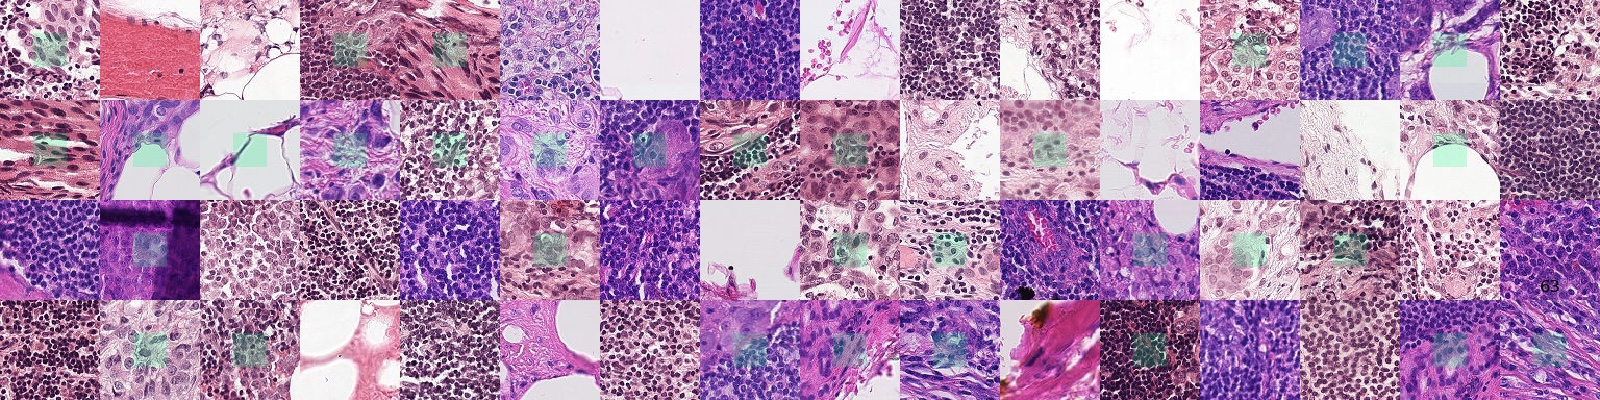

https://github.com/basveeling/pcam

The “Patch-Camelyon Database” is a benchmark image classification dataset for classification algorithms.
It consists of over 300,000 color images (96×96 pixels) extracted from histopathologic scans of lymph node
sections. Images are saved as tensors of 96×96×3 unsigned integers, with values ranging between 0 and
255, which correspond to the “R”, “B”, and “G” color channels. Each image is also annotated with a
binary label indicating the presence of metastatic tissue in the section. The Patch-Camelyon Database
can be retrieved at the URL: https://github.com/basveeling/pcam. Details on the composition and
origins of the dataset can be found in the article [1], which is attached to this assignment packet as a
PDF file for your reference (file: Bejnordi 2017.pdf).
A subset of 2,500 images and their labels from the original Patch-Camelyon Database is provided as one
*.h5 file (dataset patchcamelyon.h5) in this assigment packet. 

A 2,500×96×96×3 tensor X storing all
the images and a 2,500×1×1×1 tensor Y storing the associated labels.

Note that Y=1 indicates an image capturing metastases and Y=0 indicates an image that contains no
metastases.


# Import Libraries and Data

In [ ]:
import tensorflow as tf # TensorFlow is for DNN design and operations 
from tensorflow import keras # Keras is a module for DNN design and operations 
import numpy as np # NumPy is for numerical operations 
import matplotlib # MatPlotLib is for making plots & figures import matplotlib.pyplot as plt # PyPlot is a subset of the library for making MATLAB import h5py 
import matplotlib.pyplot as plt # PyPlot is a subset of the library for making MATLAB-style plots
from matplotlib import image
import warnings 
warnings.filterwarnings("ignore")
import h5py
import time
from sklearn.model_selection import RandomizedSearchCV

from google.colab import files
import io
import pandas as pd

print('Done!')

Done!


In [ ]:
uploaded = files.upload()

Saving dataset_patchcamelyon.h5 to dataset_patchcamelyon.h5


# Data Processing

In [ ]:
fid = h5py.File('dataset_patchcamelyon.h5', 'r') 
X, Y = fid['X'][:], fid['Y'][:] 
X = X / 255. 
fid.close()

print('Done!')

Done!


In [ ]:
# Split the data
# 2000 training, 500 testing
X_training = X[:2000,:]
X_test = X[2000:,:]
Y_training = Y[:2000]
Y_test  = Y[2000:]

# Data Augmentation
X_train_horizontal = tf.image.flip_left_right(X_training) #Flips all images horizontally
X_train_vertical = tf.image.flip_up_down(X_training) #Flips all images vertically
X_train_brighter = tf.image.adjust_brightness(X_training, 0.1) #Brightens all images
X_train_dimmer = tf.image.adjust_brightness(X_training, -0.1) #Dims all images
X_train_rot90 = tf.image.rot90(X_training, k=1) #rotates all images 90 degrees
X_train_rot270 = tf.image.rot90(X_training, k=3) #rotates all images 270 degrees

# Combine
X_train = tf.concat([X_training, X_train_horizontal, X_train_vertical, X_train_brighter, X_train_dimmer, X_train_rot90, X_train_rot270], axis=0).numpy()
Y_train = tf.concat([Y_training, Y_training, Y_training, Y_training, Y_training, Y_training, Y_training], axis=0).numpy()

# Flatten
Y_test = Y_test.reshape(-1,1)
Y_train = Y_train.reshape(-1,1)

print('Shape of X_train: ',X_train.shape)
print('Shape of X_test: ', X_test.shape)
print('Shape of Y_train: ',Y_train.shape)
print('Shape of Y_test: ', Y_test.shape)

Shape of X_train:  (14000, 96, 96, 3)
Shape of X_test:  (500, 96, 96, 3)
Shape of Y_train:  (14000, 1)
Shape of Y_test:  (500, 1)


In [ ]:
# Let us shuffle the images in the training set
shuffle_index = np.random.permutation(14000)
X_train, Y_train = X_train[shuffle_index,:], Y_train[shuffle_index]

# Set RGB Trainging Features
X_train_all = X_train
X_test_all = X_test

# Shift to gray scale to reduce amount of features
# Formula: Y = 0.299 R + 0.587 G + 0.114 B
# Dimensionality Reduction
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

X_train_gray = rgb2gray(X_train)
X_test_gray = rgb2gray(X_test)
#Convert to tensor
X_train_gray = X_train_gray[...,np.newaxis]
X_test_gray = X_test_gray[...,np.newaxis]

# Flatten X_test and X_train
X_test = X_test.reshape(-1,27648)
X_train = X_train.reshape(-1,27648)

# Print out final shapes
print('Final Shape: ')
print('Shape of X_train (gray scale): ',X_train_gray.shape)
print('Shape of X_test (gray scale): ', X_test_gray.shape)
print('Shape of X_train (rgb scale): ',X_train_all.shape)
print('Shape of X_test (rgb scale): ', X_test_all.shape)
print('Shape of Y_train: ',Y_train.shape)
print('Shape of Y_test: ', Y_test.shape)

print('\n')
print('Done!')

print('number of positive cases in training: ', np.count_nonzero(Y_train == 1))
print('number of negative cases in training: ', np.count_nonzero(Y_train == 0))

Final Shape: 
Shape of X_train (gray scale):  (14000, 96, 96, 1)
Shape of X_test (gray scale):  (500, 96, 96, 1)
Shape of X_train (rgb scale):  (14000, 96, 96, 3)
Shape of X_test (rgb scale):  (500, 96, 96, 3)
Shape of Y_train:  (14000, 1)
Shape of Y_test:  (500, 1)


Done!
number of positive cases in training:  7511
number of negative cases in training:  6489


# Initialize Environment

In [ ]:
# initialize the environment for DNN training
keras.backend.clear_session()
np.random.seed(36)
tf.random.set_seed(36)

## Create callbacks to make the training more efficient
earlystop_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

checkpoint_cb = keras.callbacks.ModelCheckpoint("model_trained.h5")

print('Done!')

Done!


# Simple Neural Network

This simple Neaural Network is to establish a baseline accuracy.

In [ ]:
## Design one simple DNN with default parameters
clf_tmp = keras.models.Sequential([
    keras.layers.Dense(100, activation='relu', input_dim=27648),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

## Compile the network model
clf_tmp.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

## Print out the structure of the network
clf_tmp.summary()

print('Done!')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2764900   
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 2,775,101
Trainable params: 2,775,101
Non-trainable params: 0
_________________________________________________________________
Done!



 Time to train:  1.1033381  minutes 



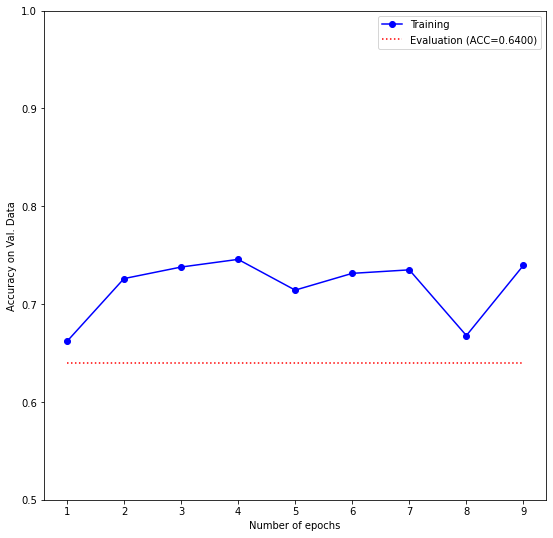

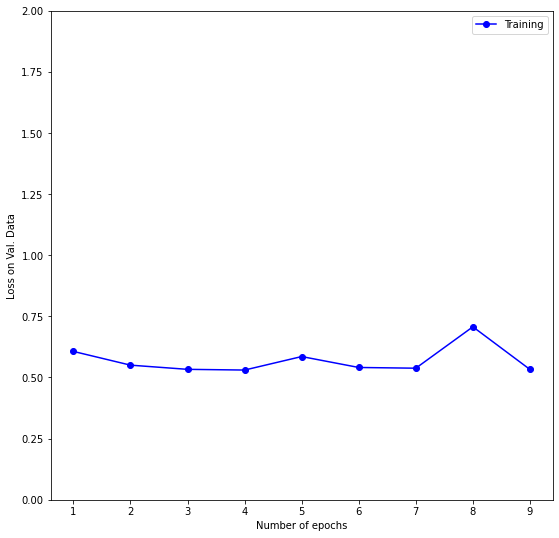

In [ ]:
## Train and validate the deep neural network
n_epochs = 1000
t0 = time.clock()
training_tmp = clf_tmp.fit(X_train, Y_train, 
                           batch_size = 200,
                           epochs=n_epochs,
                           validation_split = 0.2,
                           callbacks=[earlystop_cb], verbose=0)

print('\n Time to train: ',(time.clock() - t0)/60, ' minutes \n')

## Test the optimal network
scores1= clf_tmp.evaluate(X_test,Y_test,verbose=0)

## Plot the accuracy score versus the epochs and marks the accuracy on the test data
vals = training_tmp.history.get('val_accuracy')
loss = training_tmp.history.get('val_loss')

plt.figure(figsize=(9,9))
plt.plot(range(1,len(vals)+1), vals, color='b', marker='o',label='Training')
plt.plot([1, len(vals)], [scores1[1], scores1[1]], color='r', linestyle='dotted', label=('Evaluation (ACC=%1.4f)' %(scores1[1])))
plt.ylim(.50,1)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy on Val. Data')
plt.legend()
plt.show()

#Plot Loss
plt.figure(figsize=(9,9))

plt.plot(range(1,len(loss)+1), loss, color='b', marker='o',label='Training')

plt.ylim(0,2)

plt.xlabel('Number of epochs')
plt.ylabel('Loss on Val. Data')
plt.legend()
plt.show()

Time to explore how an optimized NN will preform. Also, if dimensionality reduction enhances classification preformance.

# Neural Network Function

This function can be called to create a Deep convolutional Neural Network with adjustable parameters. 

In [ ]:
from numpy.core.numeric import convolve
# set the template of DNN that will be used for every combination of parameters
def dnn_model(input_shape=[96,96,3],                #Shape of features
              crop=False,                           #Enables cropping 32x32 center of images (Dimesionality Reduction)
              c_layers=0,                           #Number of convolutional layers
              n_hidden=4,                           #Number of Hidden Layers
              rate = 0.2,                           #Drop Out Rate
              n_neurons=400,                         #Number of neurons for hidden layers
              activation = 'relu',                  #Activation function for hidden layers
              kernel_initializer='lecun_normal',    #Kernel Initializer for hidden layers
              learning_rate=3e-3,                   #Sets Learning rate for optimization
              n_jobs=-1):
    
    # Model and Input Layer
    dnn_clf = keras.models.Sequential()
    dnn_clf.add(keras.layers.InputLayer(input_shape=input_shape))

    if crop == True:
      #Since the cancer is in the middle 32x32 region of the image, I will crop the images in the center
      dnn_clf.add(keras.layers.CenterCrop(32, 32))
    
    # Convolutional Layers
    for C_layer in range(c_layers):
      dnn_clf.add(keras.layers.Conv2D(filters=64, kernel_size=2, activation=activation, padding="valid"))
      dnn_clf.add(keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

    #Flatten
    dnn_clf.add(keras.layers.Flatten())

    # Incorporate n_hidden number of hidden layers with batch normalization and Dropout
    for layer in range(n_hidden):
        dnn_clf.add(keras.layers.Dropout(rate=rate))
        dnn_clf.add(keras.layers.Dense(n_neurons, activation=activation, kernel_initializer=kernel_initializer, use_bias=False))

    # Output layer  
    dnn_clf.add(keras.layers.Dense(1, activation="sigmoid", use_bias=False))

    # Optimation function and compile
    optimz_vals = keras.optimizers.Adam(learning_rate=learning_rate)
    dnn_clf.compile(loss="binary_crossentropy", optimizer=optimz_vals, metrics=["accuracy"])

    return dnn_clf

print('Done!')

Done!


# More Complex NN

CNN without optimzation on RGB Features


 Time to train:  2.659851116666666  minutes 



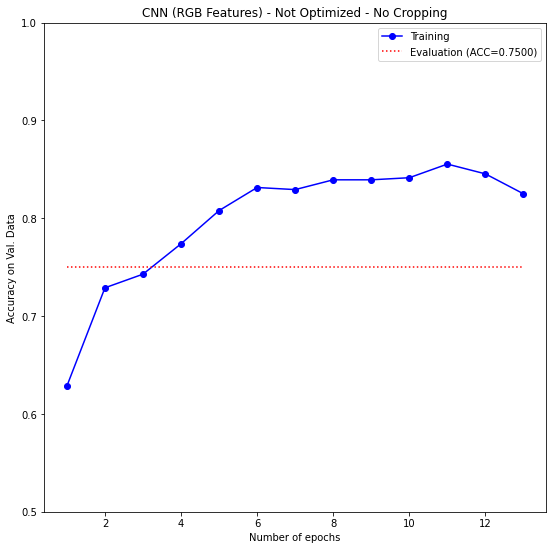

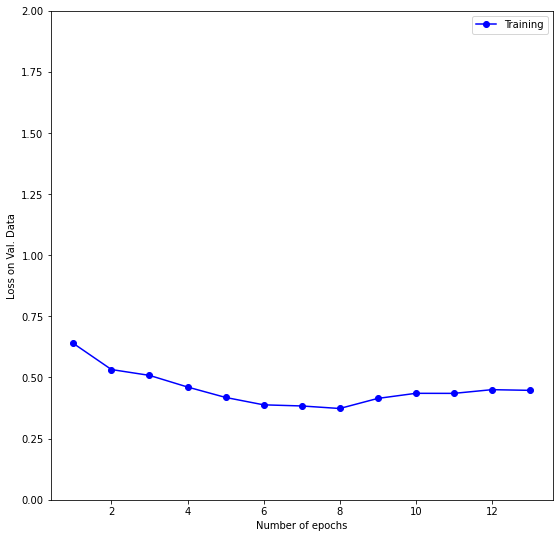

In [ ]:
# Model and Train
CNN_complex = dnn_model(rate = 0.4,
                         n_neurons = 400,
                         n_hidden = 2,
                         kernel_initializer = 'lecun_normal',
                         activation = 'relu',
                         input_shape=[96,96,3],
                         crop = False,
                         c_layers=1)

t0 = time.clock()

training_complex = CNN_complex.fit(X_train_all, Y_train,
                       batch_size = 200,
                       epochs = 100,
                       validation_split = 0.2,
                       verbose = 0,
                       callbacks=[earlystop_cb, checkpoint_cb])

print('\n Time to train: ',(time.clock() - t0)/60, ' minutes \n')

# Evaluation
scores_complex = CNN_complex.evaluate(X_test_all,Y_test,verbose=0)

vals_complex = training_complex.history.get('val_accuracy')

loss = training_complex.history.get('val_loss')

# Plot Accuracy
plt.figure(figsize=(9,9))

plt.plot(range(1,len(vals_complex)+1), vals_complex, color='b', marker='o',label='Training')
plt.plot([1, len(vals_complex)], [scores_complex[1], scores_complex[1]], color='r', linestyle='dotted', label=('Evaluation (ACC=%1.4f)' %(scores_complex[1])))

plt.ylim(.50,1)

plt.xlabel('Number of epochs')
plt.ylabel('Accuracy on Val. Data')
plt.title('CNN (RGB Features) - Not Optimized - No Cropping')
plt.legend()
plt.show()

#Plot Loss
plt.figure(figsize=(9,9))

plt.plot(range(1,len(loss)+1), loss, color='b', marker='o',label='Training')

plt.ylim(0,2)

plt.xlabel('Number of epochs')
plt.ylabel('Loss on Val. Data')
plt.legend()
plt.show()

CNN without optimzation on RGB Features (With Cropping)


 Time to train:  0.8770490333333333  minutes 



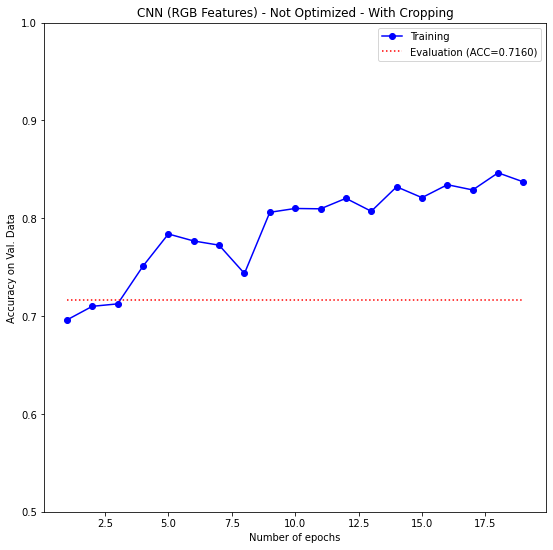

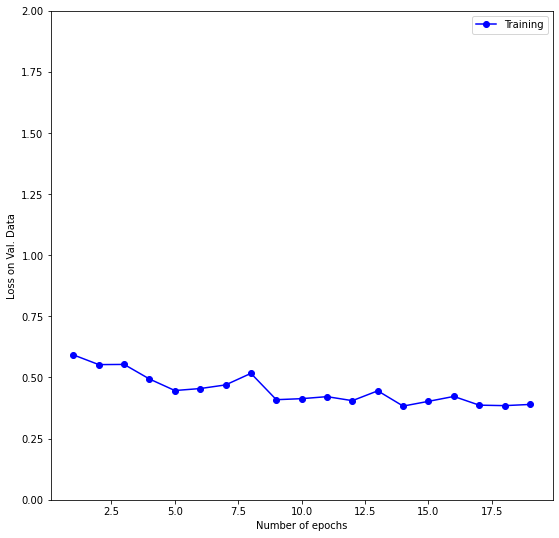

In [ ]:
# Model and Train
CNN_complex_crop = dnn_model(rate = 0.4,
                         n_neurons = 400,
                         n_hidden = 2,
                         kernel_initializer = 'lecun_normal',
                         activation = 'relu',
                         input_shape=[96,96,3],
                         crop = True,
                         c_layers = 1)

t0 = time.clock()

training_complex_crop = CNN_complex_crop.fit(X_train_all, Y_train, 
                       batch_size = 200,
                       epochs = 100,
                       validation_split = 0.2,
                       verbose = 0,
                       callbacks=[earlystop_cb, checkpoint_cb])

print('\n Time to train: ',(time.clock() - t0)/60, ' minutes \n')

# Evaluation
scores_complex_crop = CNN_complex_crop.evaluate(X_test_all,Y_test,verbose=0)

vals_complex_crop = training_complex_crop.history.get('val_accuracy')

loss = training_complex_crop.history.get('val_loss')

# Plot Accuracy
plt.figure(figsize=(9,9))

plt.plot(range(1,len(vals_complex_crop)+1), vals_complex_crop, color='b', marker='o',label='Training')
plt.plot([1, len(vals_complex_crop)], [scores_complex_crop[1], scores_complex_crop[1]], color='r', linestyle='dotted', label=('Evaluation (ACC=%1.4f)' %(scores_complex_crop[1])))

plt.ylim(.50,1)

plt.xlabel('Number of epochs')
plt.ylabel('Accuracy on Val. Data')
plt.title('CNN (RGB Features) - Not Optimized - With Cropping')
plt.legend()
plt.show()

#Plot Loss 
plt.figure(figsize=(9,9))

plt.plot(range(1,len(loss)+1), loss, color='b', marker='o',label='Training')

plt.ylim(0,2)

plt.xlabel('Number of epochs')
plt.ylabel('Loss on Val. Data')
plt.legend()
plt.show()

Gray Scale Complex CNN (No cropping)


 Time to train:  4.079210183333333  minutes 



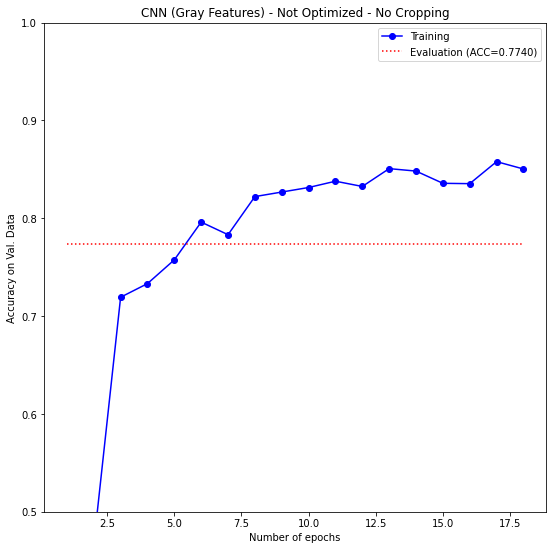

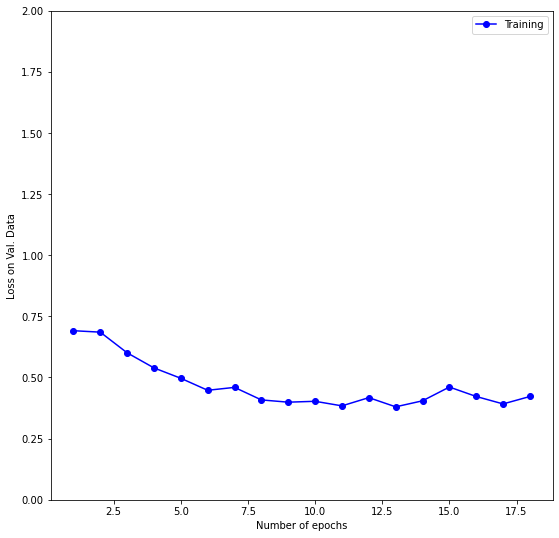

In [ ]:
# Model and Train
CNN_complex_gray = dnn_model(rate = 0.4,
                         n_neurons = 400,
                         n_hidden = 2,
                         kernel_initializer = 'lecun_normal',
                         activation = 'relu',
                         input_shape=[96,96,1],
                         crop = False,
                         c_layers = 1)

t0 = time.clock()

training_complex_gray = CNN_complex_gray.fit(X_train_gray, Y_train, batch_size = 200,
                       epochs = 100,
                       validation_split = 0.2,
                       verbose = 0,
                       callbacks=[earlystop_cb, checkpoint_cb])

print('\n Time to train: ',(time.clock() - t0)/60, ' minutes \n')

# Evaluation
scores_complex_gray = CNN_complex_gray.evaluate(X_test_gray,Y_test,verbose=0)

vals_complex_gray = training_complex_gray.history.get('val_accuracy')

loss = training_complex_gray.history.get('val_loss')

# Plot Accuracy
plt.figure(figsize=(9,9))

plt.plot(range(1,len(vals_complex_gray)+1), vals_complex_gray, color='b', marker='o',label='Training')
plt.plot([1, len(vals_complex_gray)], [scores_complex_gray[1], scores_complex_gray[1]], color='r', linestyle='dotted', label=('Evaluation (ACC=%1.4f)' %(scores_complex_gray[1])))

plt.ylim(.50,1)

plt.xlabel('Number of epochs')
plt.ylabel('Accuracy on Val. Data')
plt.title('CNN (Gray Features) - Not Optimized - No Cropping')
plt.legend()
plt.show()

#Plot Loss
plt.figure(figsize=(9,9))

plt.plot(range(1,len(loss)+1), loss, color='b', marker='o',label='Training')

plt.ylim(0,2)

plt.xlabel('Number of epochs')
plt.ylabel('Loss on Val. Data')
plt.legend()
plt.show()

Gray Scale Complex CNN (With Cropping)


 Time to train:  0.562976283333333  minutes 



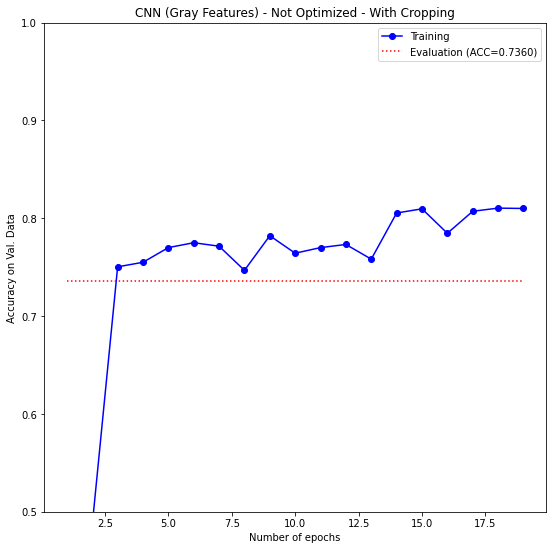

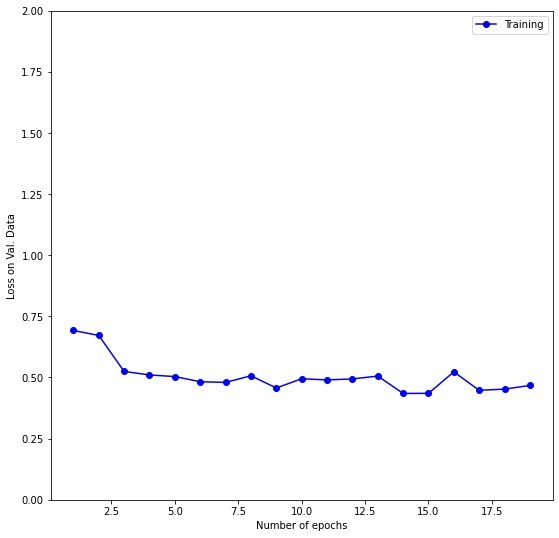

In [ ]:
# Model and Train
CNN_complex_gray_crop = dnn_model(rate = 0.4,
                         n_neurons = 400,
                         n_hidden = 2,
                         kernel_initializer = 'lecun_normal',
                         activation = 'relu',
                         input_shape=[96,96,1],
                         crop = True,
                         c_layers=1)

t0 = time.clock()

training_complex_gray_crop = CNN_complex_gray_crop.fit(X_train_gray, Y_train, batch_size = 200,
                       epochs = 100,
                       validation_split = 0.2,
                       verbose = 0,
                       callbacks=[earlystop_cb, checkpoint_cb])

print('\n Time to train: ',(time.clock() - t0)/60, ' minutes \n')

# Evaluation
scores_complex_gray_crop = CNN_complex_gray_crop.evaluate(X_test_gray,Y_test,verbose=0)
loss = training_complex_gray_crop.history.get('val_loss')
vals_complex_gray_crop = training_complex_gray_crop.history.get('val_accuracy')

# Plot Accuracy
plt.figure(figsize=(9,9))

plt.plot(range(1,len(vals_complex_gray_crop)+1), vals_complex_gray_crop, color='b', marker='o',label='Training')
plt.plot([1, len(vals_complex_gray_crop)], [scores_complex_gray_crop[1], scores_complex_gray_crop[1]], color='r', linestyle='dotted', label=('Evaluation (ACC=%1.4f)' %(scores_complex_gray_crop[1])))

plt.ylim(.50,1)

plt.xlabel('Number of epochs')
plt.ylabel('Accuracy on Val. Data')
plt.title('CNN (Gray Features) - Not Optimized - With Cropping')
plt.legend()
plt.show()

#Plot Loss
plt.figure(figsize=(9,9))

plt.plot(range(1,len(loss)+1), loss, color='b', marker='o',label='Training')

plt.ylim(0,2)

plt.xlabel('Number of epochs')
plt.ylabel('Loss on Val. Data')
plt.legend()
plt.show()

In [ ]:
print('Accuracy of simple NN (RGB Features): ', scores1[1], '\n')

print('With Data Augmentation:')
print('Accuracy of CNN (RGB Features) - No Cropping: ', scores_complex[1])
print('Accuracy of CNN (RGB Features) - With Cropping: ', scores_complex_crop[1])
print('Accuracy of CNN (Gray Features) - No Cropping: ', scores_complex_gray[1])
print('Accuracy of CNN (Gray Features) - With Cropping: ', scores_complex_gray_crop[1])

# Optimization

Run this section to find optimal parameters for:

RGB (no crop)

RGB (with crop)

GRAY (no crop)

Gray (with crop)

Then Update parameters in Optimized NN section

RGB Features Random Search Cross Validation (No Cropping)

In [ ]:
# set the range of parameters to test
param_distribs = {
    # 27 combinations
    "n_hidden": [2,3,4],
    'c_layers': [1,2,3],
    "n_neurons": [200,300,400],
    # constant parameters
    "rate": [0.2],
    'input_shape': [[96,96,3]],
    'crop': [False]
    }


# create a wrapper to use the DNN as any other classifier in scikit-learn
clftemp2 = keras.wrappers.scikit_learn.KerasClassifier(dnn_model)

t0 = time.clock()
#search 1
search_cv = RandomizedSearchCV(clftemp2, param_distribs, cv = 3, 
                                   n_iter=15, scoring= 'accuracy',
                                   return_train_score=False,
                                   verbose=1)

search_cv.fit(X_train_all, Y_train, 
              batch_size=200,
              epochs=100,
              validation_split = 0.2,
              verbose = 0, callbacks=[earlystop_cb, checkpoint_cb])

print('\n Time to search: ',(time.clock() - t0)/60, ' minutes')


CNN = search_cv.best_params_
print(CNN)

param_distribs = {
    #Best Parameters
    "n_hidden": CNN[['n_hidden']],
    'c_layers': CNN[['c_layers']],
    "n_neurons": CNN[['n_neurons']],
    # 18 Combinations
    "rate": [0,0.1,0.2,0.3,0.4,0.5],
    'learning_rate': np.logspace(-4, -1,num=3).tolist(),
    # Constants
    'input_shape': [[96,96,3]],
    'crop': [False]
    }
#search 2
search_cv = RandomizedSearchCV(clftemp2, param_distribs, cv = 3, 
                                   n_iter=10, scoring= 'accuracy',
                                   return_train_score=False,
                                   verbose=1)

search_cv.fit(X_train_all, Y_train, 
              batch_size=200,
              epochs=100,
              validation_split = 0.2,
              verbose = 0, callbacks=[earlystop_cb])

CNN = search_cv.best_params_
print(CNN)

print('\n Time to search: ',(time.clock() - t0)/60, ' minutes')

RGB Features Random Search Cross Validation (With Cropping)

In [ ]:
# set the range of parameters to test
param_distribs = {
    # 27 combinations
    "n_hidden": [2,3,4],
    'c_layers': [1,2,3],
    "n_neurons": [200,300,400],
    # constant parameters
    "rate": [0.2],
    'input_shape': [[96,96,3]],
    'crop': [True]
    }


# create a wrapper to use the DNN as any other classifier in scikit-learn
clftemp2 = keras.wrappers.scikit_learn.KerasClassifier(dnn_model)

t0 = time.clock()
#search 1
search_cv = RandomizedSearchCV(clftemp2, param_distribs, cv = 3, 
                                   n_iter=15, scoring= 'accuracy',
                                   return_train_score=False,
                                   verbose=1)

search_cv.fit(X_train_all, Y_train, 
              batch_size=200,
              epochs=100,
              validation_split = 0.2,
              verbose = 0, callbacks=[earlystop_cb])

print('\n Time to search: ',(time.clock() - t0)/60, ' minutes')


CNN = search_cv.best_params_
print(CNN)

param_distribs = {
    #Best Parameters
    "n_hidden": CNN[['n_hidden']],
    'c_layers': CNN[['c_layers']],
    "n_neurons": CNN[['n_neurons']],
    # 18 Combinations
    "rate": [0,0.1,0.2,0.3,0.4,0.5],
    'learning_rate': np.logspace(-4, -1,num=3).tolist(),
    # Constants
    'input_shape': [[96,96,3]],
    'crop': [True]
    }
#search 2
search_cv = RandomizedSearchCV(clftemp2, param_distribs, cv = 3, 
                                   n_iter=10, scoring= 'accuracy',
                                   return_train_score=False,
                                   verbose=1)

search_cv.fit(X_train_all, Y_train, 
              batch_size=200,
              epochs=100,
              validation_split = 0.2,
              verbose = 0, callbacks=[earlystop_cb])

CNN = search_cv.best_params_
print(CNN)

print('\n Time to search: ',(time.clock() - t0)/60, ' minutes')

Gray Scale Random Search Cross Validation

No Cropping

In [ ]:
# set the range of parameters to test
param_distribs = {
    # 27 combinations
    "n_hidden": [2,3,4],
    'c_layers': [1,2,3],
    "n_neurons": [200,300,400],
    # constant parameters
    "rate": [0.2],
    'input_shape': [[96,96,3]],
    'crop': [False]
    }


# create a wrapper to use the DNN as any other classifier in scikit-learn
clftemp2 = keras.wrappers.scikit_learn.KerasClassifier(dnn_model)

t0 = time.clock()
#search 1
search_cv = RandomizedSearchCV(clftemp2, param_distribs, cv = 3, 
                                   n_iter=15, scoring= 'accuracy',
                                   return_train_score=False,
                                   verbose=1)

search_cv.fit(X_train_all, Y_train, 
              batch_size=200,
              epochs=100,
              validation_split = 0.2,
              verbose = 0, callbacks=[earlystop_cb, checkpoint_cb])

print('\n Time to search: ',(time.clock() - t0)/60, ' minutes')


CNN = search_cv.best_params_
print(CNN)

param_distribs = {
    #Best Parameters
    "n_hidden": [CNN['n_hidden']],
    'c_layers': [CNN['c_layers']],
    "n_neurons": [CNN['n_neurons']],
    # 18 Combinations
    "rate": [0,0.1,0.2,0.3,0.4,0.5],
    'learning_rate': np.logspace(-4, -1,num=3).tolist(),
    # Constants
    'input_shape': [[96,96,3]],
    'crop': [False]
    }
#search 2
search_cv = RandomizedSearchCV(clftemp2, param_distribs, cv = 3, 
                                   n_iter=10, scoring= 'accuracy',
                                   return_train_score=False,
                                   verbose=1)

search_cv.fit(X_train_all, Y_train, 
              batch_size=200,
              epochs=100,
              validation_split = 0.2,
              verbose = 0, callbacks=[earlystop_cb])

DNN_gray = search_cv.best_params_
print(DNN_gray)

print('\n Time to search: ',(time.clock() - t0)/60, ' minutes')

Gray Scale Random Search Cross Validation

With Cropping

In [ ]:
# set the range of parameters to test
param_distribs = {
    # 27 combinations
    "n_hidden": [2,3,4],
    'c_layers': [1,2,3],
    "n_neurons": [200,300,400],
    # constant parameters
    "rate": [0.2],
    'input_shape': [[96,96,1]],
    'crop': [True]
    }


# create a wrapper to use the DNN as any other classifier in scikit-learn
clftemp2 = keras.wrappers.scikit_learn.KerasClassifier(dnn_model)

t0 = time.clock()
#search 1
search_cv = RandomizedSearchCV(clftemp2, param_distribs, cv = 3, 
                                   n_iter=15, scoring= 'accuracy',
                                   return_train_score=False,
                                   verbose=1)

search_cv.fit(X_train_gray, Y_train, 
              batch_size=200,
              epochs=100,
              validation_split = 0.2,
              verbose = 0, callbacks=[earlystop_cb])

print('\n Time to search: ',(time.clock() - t0)/60, ' minutes')


CNN = search_cv.best_params_
print(CNN)

param_distribs = {
    #Best Parameters
    "n_hidden": [CNN['n_hidden']],
    'c_layers': [CNN['c_layers']],
    "n_neurons": [CNN['n_neurons']],
    # 18 Combinations
    "rate": [0,0.1,0.2,0.3,0.4,0.5],
    'learning_rate': np.logspace(-4, -1,num=3).tolist(),
    # Constants
    'input_shape': [[96,96,1]],
    'crop': [True]
    }
#search 2
search_cv = RandomizedSearchCV(clftemp2, param_distribs, cv = 3, 
                                   n_iter=10, scoring= 'accuracy',
                                   return_train_score=False,
                                   verbose=1)

search_cv.fit(X_train_gray, Y_train, 
              batch_size=200,
              epochs=100,
              validation_split = 0.2,
              verbose = 0, callbacks=[earlystop_cb])

DNN_gray_crop = search_cv.best_params_
print(DNN_gray_crop)

print('\n Time to search: ',(time.clock() - t0)/60, ' minutes')

# Optimized NN

NN (all features) optimized using All Features Random Search CV results

In [ ]:
# Create a callback function to stop training early if no improvement happens for 5 epochs
earlystop_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Best Parameters (From Optimization Section)
CNN = {
    "n_hidden": 4,
    "n_neurons": 400,
    "activation": 'relu',
    "kernel_initializer": 'LecunNormal',
    "rate": 0.4,
    'learning_rate': 0.0001,
    'c_layers': 3
}

CNN_crop = {
    "n_hidden": 4,
    "n_neurons": 200,
    "activation": 'relu',
    "kernel_initializer": 'LecunNormal',
    "rate": 0.2,
    'learning_rate': 0.0001,
    'c_layers': 3
}

# create the model with the best parameters 
cnn_opt = dnn_model(rate = CNN['rate'],
                         n_neurons = CNN['n_neurons'],
                         n_hidden = CNN['n_hidden'],
                         learning_rate = CNN['learning_rate'],
                         kernel_initializer = CNN['kernel_initializer'],
                         activation = CNN['activation'],
                         c_layers = CNN['c_layers'],
                         input_shape=[96,96,3],
                         crop = False)

cnn_opt_crop = dnn_model(rate = CNN_crop['rate'],
                         n_neurons = CNN_crop['n_neurons'],
                         n_hidden = CNN_crop['n_hidden'],
                         learning_rate = CNN_crop['learning_rate'],
                         kernel_initializer = CNN_crop['kernel_initializer'],
                         activation = CNN_crop['activation'],
                         c_layers = CNN_crop['c_layers'],
                         input_shape=[96,96,3],
                         crop = True)

t0 = time.clock()
# train the optimal network
training_cnn = cnn_opt.fit(X_train_all, Y_train,
                       batch_size = 200,
                       epochs = 100,
                       validation_split = 0.2,
                       verbose = 0,
                       callbacks=[earlystop_cb])

training_cnn_crop = cnn_opt_crop.fit(X_train_all, Y_train,
                       batch_size = 200,
                       epochs = 100,
                       validation_split = 0.2,
                       verbose = 0,
                       callbacks=[earlystop_cb])

print('\n Time to train: ',(time.clock() - t0)/60, ' minutes')

# test the optimal network
scores_cnn = cnn_opt.evaluate(X_test_all,Y_test,verbose=0)
scores_cnn_crop = cnn_opt_crop.evaluate(X_test_all,Y_test,verbose=0)

print('Accuracy of CNN (RGB Features) - No Cropping: ', scores_cnn[1])
print('Accuracy of CNN (RGB Features) - With Cropping: ', scores_cnn_crop[1])


 Time to train:  9.643410033333334  minutes
Accuracy of CNN (RGB Features) - No Cropping:  0.8080000281333923
Accuracy of CNN (RGB Features) - With Cropping:  0.7879999876022339


DNNs - Gray Scale

In [ ]:
# Create a callback function to stop training early if no improvement happens for 5 epochs
earlystop_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Best Parameters (From Optimization Section)
DNN_gray = {
    "n_hidden": 4,
    "n_neurons": 400,
    "activation": 'relu',
    "kernel_initializer": 'LecunNormal',
    "rate": 0.5,
    'learning_rate': 0.0001,
    'c_layers': 3
}

DNN_gray_crop = {
    "n_hidden": 4,
    "n_neurons": 200,
    "activation": 'relu',
    "kernel_initializer": 'LecunNormal',
    "rate": 0.5,
    'learning_rate': 0.0001,
    'c_layers': 2
}


# create the model with the best parameters
cnn_opt_gray = dnn_model(rate = DNN_gray['rate'],
                         n_neurons = DNN_gray['n_neurons'],
                         n_hidden = DNN_gray['n_hidden'],
                         learning_rate = DNN_gray['learning_rate'],
                         kernel_initializer = DNN_gray['kernel_initializer'],
                         activation = DNN_gray['activation'],
                         c_layers = DNN_gray['c_layers'],
                         crop = False,
                         input_shape = [96,96,1])

cnn_opt_gray_crop = dnn_model(rate = DNN_gray_crop['rate'],
                         n_neurons = DNN_gray_crop['n_neurons'],
                         n_hidden = DNN_gray_crop['n_hidden'],
                         learning_rate = DNN_gray_crop['learning_rate'],
                         kernel_initializer = DNN_gray_crop['kernel_initializer'],
                         activation = DNN_gray_crop['activation'],
                         c_layers = DNN_gray['c_layers'],
                         crop = True,
                         input_shape = [96,96,1])


# train the optimal network
training_gray = cnn_opt_gray.fit(X_train_gray, Y_train,
                       batch_size = 200,
                       epochs = 100,
                       validation_split = 0.2,
                       verbose = 0,
                       callbacks=[earlystop_cb])

training_gray_crop = cnn_opt_gray_crop.fit(X_train_gray, Y_train,
                       batch_size = 200,
                       epochs = 100,
                       validation_split = 0.2,
                       verbose = 0,
                       callbacks=[earlystop_cb])


# test the optimal network
scores3 = cnn_opt_gray.evaluate(X_test_gray,Y_test,verbose=0)
scores3_crop = cnn_opt_gray_crop.evaluate(X_test_gray,Y_test,verbose=0)


print('Accuracy of CNN (Gray Features) - No Cropping: ', scores3[1])
print('Accuracy of CNN (Gray Features) - With Cropping: ', scores3_crop[1])

Accuracy of CNN (Gray Features) - No Cropping:  0.7940000295639038
Accuracy of CNN (Gray Features) - With Cropping:  0.765999972820282


# Accuracy, Precision, Recall, and F1 score

Accuracy Plot

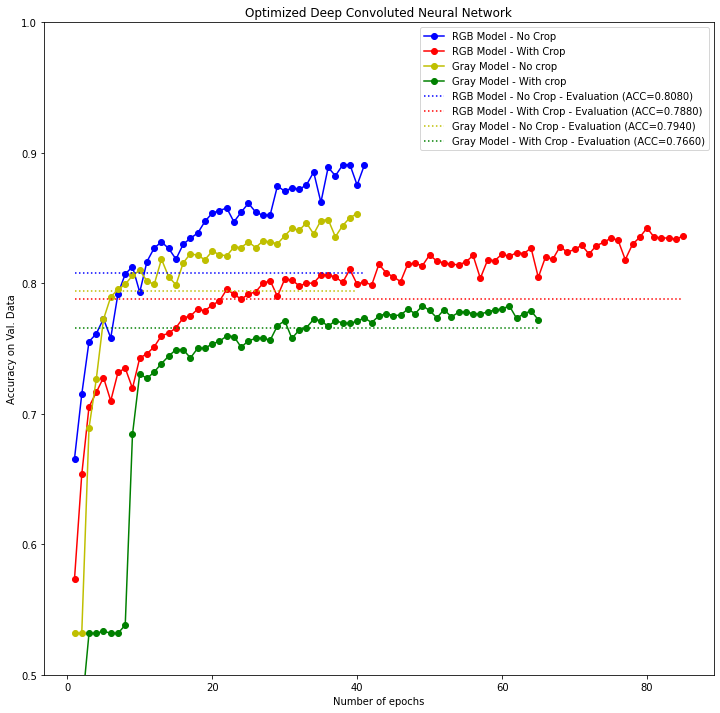

In [ ]:
# Plot the accuracy score versus the epochs and marks the accuracy on the test data
vals_cnn = training_cnn.history.get('val_accuracy')
vals_cnn_crop = training_cnn_crop.history.get('val_accuracy')
vals3 = training_gray.history.get('val_accuracy')
vals3_crop = training_gray_crop.history.get('val_accuracy')


plt.figure(figsize=(12,12))

plt.plot(range(1,len(vals_cnn)+1), vals_cnn, color='b', marker='o',label='RGB Model - No Crop')
plt.plot(range(1,len(vals_cnn_crop)+1), vals_cnn_crop, color='r', marker='o',label='RGB Model - With Crop')
plt.plot(range(1,len(vals3)+1), vals3, color='y', marker='o',label='Gray Model - No crop')
plt.plot(range(1,len(vals3_crop)+1), vals3_crop, color='g', marker='o',label='Gray Model - With crop')

plt.plot([1, len(vals_cnn)], [scores_cnn[1], scores_cnn[1]], color='b', linestyle='dotted', label=('RGB Model - No Crop - Evaluation (ACC=%1.4f)' %(scores_cnn[1])))
plt.plot([1, len(vals_cnn_crop)], [scores_cnn_crop[1], scores_cnn_crop[1]], color='r', linestyle='dotted', label=('RGB Model - With Crop - Evaluation (ACC=%1.4f)' %(scores_cnn_crop[1])))
plt.plot([1, len(vals3)], [scores3[1], scores3[1]], color='y', linestyle='dotted', label=('Gray Model - No Crop - Evaluation (ACC=%1.4f)' %(scores3[1])))
plt.plot([1, len(vals3_crop)], [scores3_crop[1], scores3_crop[1]], color='g', linestyle='dotted', label=('Gray Model - With Crop - Evaluation (ACC=%1.4f)' %(scores3_crop[1])))

plt.ylim(.50,1)

plt.xlabel('Number of epochs')
plt.ylabel('Accuracy on Val. Data')
plt.title('Optimized Deep Convoluted Neural Network')
plt.legend()
plt.show()

Accuracy, Precision, Recall, and F1 score

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize


# Predictions
Y_pred_RGB = np.round_(cnn_opt.predict(X_test_all))
Y_pred_RGB_crop = np.round_(cnn_opt_crop.predict(X_test_all))
Y_pred_gray = np.round_(cnn_opt_gray.predict(X_test_gray))
Y_pred_gray_crop = np.round_(cnn_opt_gray_crop.predict(X_test_gray))

Y_pred_RGB_a = cnn_opt.predict(X_test_all)
Y_pred_RGB_crop_a = cnn_opt_crop.predict(X_test_all)
Y_pred_gray_a = cnn_opt_gray.predict(X_test_gray)
Y_pred_gray_crop_a = cnn_opt_gray_crop.predict(X_test_gray)

Y_pred = [Y_pred_RGB, Y_pred_RGB_crop, Y_pred_gray, Y_pred_gray_crop]
Y_pred_proba = [Y_pred_RGB_a, Y_pred_RGB_crop_a, Y_pred_gray_a, Y_pred_gray_crop_a]

## Let us measure Precision, Recall, Accuracy, and F1 Score
for i in range(0,4):
    acc = accuracy_score(Y_test, Y_pred[i])
    pre = precision_score(Y_test, Y_pred[i], average = 'weighted')
    rec = recall_score(Y_test, Y_pred[i], average = 'weighted')
    f1s = f1_score(Y_test, Y_pred[i], average = 'weighted')

    if (i==0):
        labelval = 'RGB Model           '
    if (i==1):
        labelval = 'RGB Model with Crop '
    if (i==2):
        labelval = 'Gray Model          '
    if (i==3):
        labelval = 'Gray Model with Crop'
    print('%s: Acc=%1.4f \t Prec=%1.4f \t Recall=%1.4f \t F1 score=%1.4f' % (labelval,acc,pre,rec,f1s))

RGB Model           : Acc=0.8080 	 Prec=0.8114 	 Recall=0.8080 	 F1 score=0.8078
RGB Model with Crop : Acc=0.7880 	 Prec=0.7923 	 Recall=0.7880 	 F1 score=0.7877
Gray Model          : Acc=0.7940 	 Prec=0.8022 	 Recall=0.7940 	 F1 score=0.7932
Gray Model with Crop: Acc=0.7660 	 Prec=0.7820 	 Recall=0.7660 	 F1 score=0.7637


# Error Analysis

Confusion Matricies

RGB Model - No Crop - Error Matrix


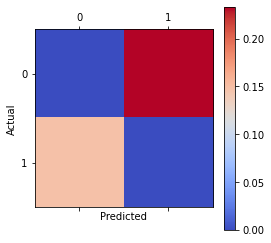



RGB Model - With Crop - Error Matrix


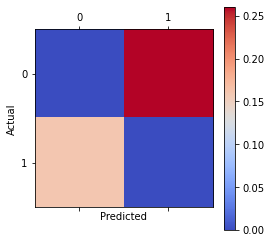



Gray Model - No Crop - Error Matrix


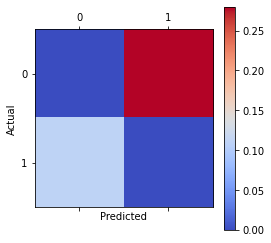



Gray Model - With Crop - Error Matrix


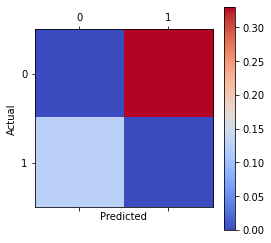

In [ ]:
from sklearn.metrics import confusion_matrix

# RGB Model No Crop
print('RGB Model - No Crop - Error Matrix')
CM0 = confusion_matrix(Y_test, Y_pred_RGB)
CM0 = CM0.astype('float') / CM0.sum(axis=1)[:, np.newaxis]   
np.fill_diagonal(CM0,0)
plt.matshow(CM0, cmap=plt.cm.coolwarm)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout
plt.colorbar()
plt.show()
print('\n')

# RGB Model With Crop
print('RGB Model - With Crop - Error Matrix')
CM0 = confusion_matrix(Y_test, Y_pred_RGB_crop)
CM0 = CM0.astype('float') / CM0.sum(axis=1)[:, np.newaxis]   
np.fill_diagonal(CM0,0)
plt.matshow(CM0, cmap=plt.cm.coolwarm)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout
plt.colorbar()
plt.show()
print('\n')

# Gray Model No Crop
print('Gray Model - No Crop - Error Matrix')
CM0 = confusion_matrix(Y_test, Y_pred_gray)
CM0 = CM0.astype('float') / CM0.sum(axis=1)[:, np.newaxis]   
np.fill_diagonal(CM0,0)
plt.matshow(CM0, cmap=plt.cm.coolwarm)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout
plt.colorbar()
plt.show()
print('\n')

# Gray Model With Crop
print('Gray Model - With Crop - Error Matrix')
CM0 = confusion_matrix(Y_test, Y_pred_gray_crop)
CM0 = CM0.astype('float') / CM0.sum(axis=1)[:, np.newaxis]   
np.fill_diagonal(CM0,0)
plt.matshow(CM0, cmap=plt.cm.coolwarm)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout
plt.colorbar()
plt.show()
print('\n')

# ROC / AUC Curve

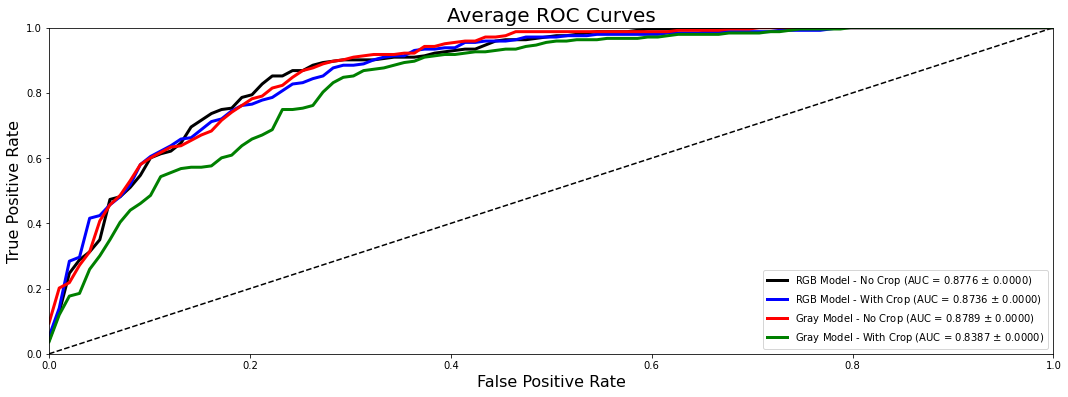

In [ ]:
Y_bin = label_binarize(Y_test, classes=range(0,2))

## Let us compare the average ROC curves
plt.figure(1, figsize=(18, 6))
plt.clf()
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Average ROC Curves', fontsize=20)
Fpr_mean = np.linspace(0, 1, 100)

for i in range(0,4):
    tpr_mean = []
    AUC = []
    Y_prob = Y_pred_proba[i]
    
    if (i==0):
        labelval = 'RGB Model - No Crop'
        colorval = 'k'
        linesval = 'solid'
    if (i==1):
        labelval = 'RGB Model - With Crop'
        colorval = 'b'
        linesval = 'solid'
    if (i==2):
        labelval = 'Gray Model - No Crop'
        colorval = 'r'
        linesval = 'solid'
    if (i==3):
        labelval = 'Gray Model - With Crop'
        colorval = 'g'
        linesval = 'solid'

    for j in range(0,np.size(Y_bin,1)):
        fpr, tpr, T = roc_curve(Y_bin[:,j], Y_prob[:,j])
        AUC.append(roc_auc_score(Y_bin[:,j], Y_prob[:,j]))
        tpr_mean.append(np.interp(Fpr_mean, fpr, tpr))
    Tpr_mean = np.mean(tpr_mean, axis=0)
    mean_auc = auc(Fpr_mean, Tpr_mean)
    std_auc = np.std(AUC)
    plt.plot(Fpr_mean, Tpr_mean, color=colorval, linewidth=3, linestyle=linesval,
             label=r'%s (AUC = %0.4f $\pm$ %0.4f)' % (labelval, mean_auc, std_auc))
plt.legend(loc='lower right')
plt.show()